Library


In [404]:
import pickle
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import skfuzzy as fuzz
from skfuzzy import control as ctrl

Main Path


In [405]:
PATH_MAIN = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# PATH_MAIN = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

PATH_DATASET = f"{PATH_MAIN}/Dataset"

Konstanta


In [406]:
SAMPLE_RATE = 48000
BATCH_SIZE = 32
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)
RANDOM_STATE = 21
BUFFER_SIZE = 1000

Random Seed


In [407]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Dataset


Load Dataset Raw


In [408]:
with open(f"{PATH_DATASET}/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [409]:
len(dataset)

1894

In [410]:
dataset[0]

{'nama': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
 'timestamp': [0.0, 1.0],
 'label': 2,
 'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
         1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
 'rms': 0.011059444,
 'max_amp': 0.08531428,
 'max_slope': 0.06221871,
 'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
         -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
        [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
         -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
        [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
         -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
          7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
        [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
          5.2022276e+00,  3.3751645e+00, -6.7336679e+00],
       

`Label 1 untuk suara non-burung dan 0 untuk suara burung`


Assign variabel X dan y


In [411]:
dataset

[{'nama': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'timestamp': [0.0, 1.0],
  'label': 2,
  'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
          1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
  'rms': 0.011059444,
  'max_amp': 0.08531428,
  'max_slope': 0.06221871,
  'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
          -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
         [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
          -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
         [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
          -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
           7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
         [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
           5.2022276e+00,  3.3751645e+00, -6.73

In [412]:
feature = ["rms", "spectral_flatness"]

X = [[data[f] for f in feature] for data in dataset]
original_labels = [int(data["label"]) for data in dataset]
y = [1 if label == 0 or label == 1 else 2 for label in original_labels]
# y = [int(data["label"]) for data in dataset]

Check


In [413]:
pd.Series(y).value_counts()

1    1335
2     559
Name: count, dtype: int64

In [414]:
print("Data:\n", X[0])
print("Label: ", y[0])

Data:
 [0.011059444, 0.011423797]
Label:  2


Split


In [415]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_test)

Normalisasi


In [416]:
scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)
X_val_scaled = scl.transform(X_val)

Save scaler


In [417]:
joblib.dump(scl, f'{PATH_MAIN}/model/p_scaler.pkl')

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar/model/p_scaler.pkl']

Check


In [418]:
display(
    X_train_scaled.shape,
    X_test_scaled.shape,
    X_val_scaled.shape
)

(1515, 2)

(189, 2)

(190, 2)

In [419]:
list_rms = [x[0] for x in X_train_scaled]
list_flat = [x[1] for x in X_train_scaled]

print(np.min(list_rms), np.max(list_rms))
print(np.min(list_flat), np.max(list_flat))

-0.7139386625068701 6.965119766026033
-0.33812428640170455 3.46926849711127


In [420]:
list_rms = [x[0] for x in X_val_scaled]
list_flat = [x[1] for x in X_val_scaled]

print(np.min(list_rms), np.max(list_rms))
print(np.min(list_flat), np.max(list_flat))

-0.7139386625068701 4.676324546121086
-0.33810198565403826 3.46926849711127


In [421]:
list_rms = [x[0] for x in X_test_scaled]
list_flat = [x[1] for x in X_test_scaled]

print(np.min(list_rms), np.max(list_rms))
print(np.min(list_flat), np.max(list_flat))

-0.7139386625068701 6.8237174053405365
-0.3381235207522287 3.46926849711127


# Train


Model yang akan digunakan untuk klasifikasi suara burung:

1. Fuzzy Mamdani
2. Fuzzy Sugeno
3. Logistic Regression
4. Descision Tree
5. LGBM Classifier


## Fuzzy Mamdani


inisialisasi


In [422]:
rms = ctrl.Antecedent(np.linspace(0, 0.5, 100), 'rms')
flatness = ctrl.Antecedent(np.linspace(0, 1, 100), 'flatness')
label = ctrl.Consequent(np.linspace(1, 2, 100), 'label')

rms['low'] = fuzz.gaussmf(rms.universe, 0.01, 0.005)
rms['medium'] = fuzz.gaussmf(rms.universe, 0.03, 0.005)
rms['high'] = fuzz.gaussmf(rms.universe, 0.35, 0.12)

flatness['rigid'] = fuzz.gaussmf(flatness.universe, 0.005, 0.002)
flatness['soft'] = fuzz.gaussmf(flatness.universe, 0.01, 0.002)
flatness['flat'] = fuzz.gaussmf(flatness.universe, 0.75, 0.15)

label[1] = fuzz.gaussmf(label.universe, 1, 0.1)
label[2] = fuzz.gaussmf(label.universe, 2, 0.1)

rule1 = ctrl.Rule(rms['low'] & flatness['flat'], label[2])
rule2 = ctrl.Rule(rms['low'] & flatness['soft'], label[1])
rule3 = ctrl.Rule(rms['medium'] & flatness['flat'], label[1])
rule4 = ctrl.Rule(rms['high'] | flatness['rigid'], label[1])
rule5 = ctrl.Rule(rms['medium'] & flatness['soft'], label[1])

mamdani_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
mamdani_sim = ctrl.ControlSystemSimulation(mamdani_ctrl)

Visualisasi


C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


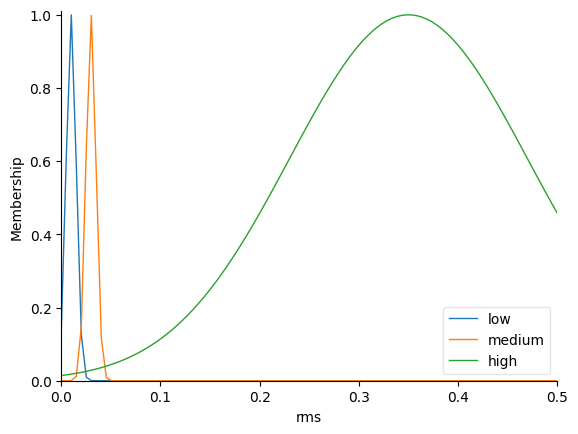

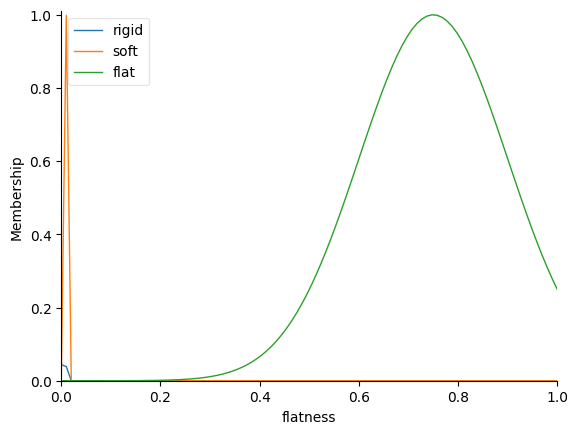

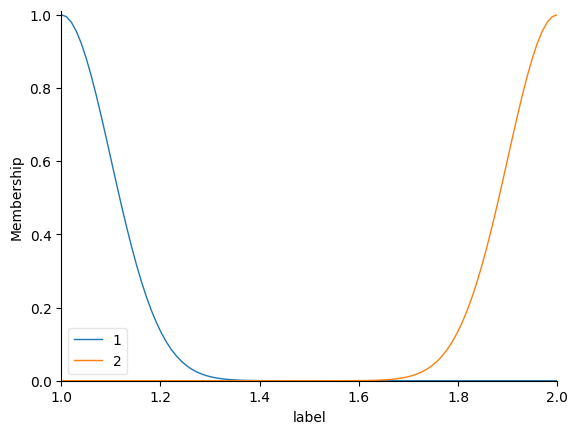

In [423]:
rms.view()
flatness.view()
label.view()

inferensi


In [424]:
def inferensi_mamdani(X_test):
    y_pred = []

    for xi in X_test:
        mamdani_sim.input['rms'] = xi[0]
        mamdani_sim.input['flatness'] = xi[1]
        
        try:
            mamdani_sim.compute()
            output_value = mamdani_sim.output['label']
            
            if output_value > 1.25:
                y_pred.append(2)
            else:
                y_pred.append(1)
        except:
            y_pred.append(1)
    
    return np.array(y_pred)

evaluasi


In [425]:
X_vt = X_val + X_test
y_vt = y_val + y_test

In [426]:
y_pred = inferensi_mamdani(X_val)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.8315789473684211
Precision: 0.8109756097560976
Recall: 0.9925373134328358
F1 Score: 0.8926174496644296
Confusion Matrix:
 [[133   1]
 [ 31  25]]


In [427]:
y_pred = inferensi_mamdani(X_test)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Validasi
Accuracy: 0.783068783068783
Precision: 0.764367816091954
Recall: 1.0
F1 Score: 0.8664495114006515
Confusion Matrix:
 [[133   0]
 [ 41  15]]


In [428]:
y_pred = inferensi_mamdani(X_vt)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_vt, y_pred)}")
print(f"Precision: {precision_score(y_vt, y_pred)}")
print(f"Recall: {recall_score(y_vt, y_pred)}")
print(f"F1 Score: {f1_score(y_vt, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_vt, y_pred)}")

Validasi
Accuracy: 0.8073878627968337
Precision: 0.7869822485207101
Recall: 0.9962546816479401
F1 Score: 0.8793388429752066
Confusion Matrix:
 [[266   1]
 [ 72  40]]


## Fuzzy Sugeno


## Logistic Regression


Inisialisasi


In [429]:
lr_model = LogisticRegression(random_state=RANDOM_STATE)

training


In [430]:
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=21)

evaluasi


In [431]:
y_pred = lr_model.predict(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.8947368421052632
Precision: 0.9384615384615385
Recall: 0.9104477611940298
F1 Score: 0.9242424242424242
Confusion Matrix:
 [[122  12]
 [  8  48]]


In [432]:
y_pred = lr_model.predict(X_test_scaled)

print("Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Test
Accuracy: 0.9259259259259259
Precision: 0.9280575539568345
Recall: 0.9699248120300752
F1 Score: 0.9485294117647058
Confusion Matrix:
 [[129   4]
 [ 10  46]]


## Descision Tree


Inisialisasi


In [433]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

training


In [434]:
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=21)

evaluasi


In [435]:
y_pred = dt_model.predict(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.9421052631578948
Precision: 0.9767441860465116
Recall: 0.9402985074626866
F1 Score: 0.9581749049429658
Confusion Matrix:
 [[126   8]
 [  3  53]]


In [436]:
y_pred = dt_model.predict(X_test_scaled)

print("Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Test
Accuracy: 0.9470899470899471
Precision: 0.9424460431654677
Recall: 0.9849624060150376
F1 Score: 0.9632352941176471
Confusion Matrix:
 [[131   2]
 [  8  48]]


## LGBM


Inisialisasi


In [437]:
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

training


In [438]:
lgbm_model.fit(X_train_scaled, y_train)

LGBMClassifier(random_state=21, verbose=-1)

evaluasi


In [439]:
y_pred = lgbm_model.predict(X_val_scaled)

print("Validasi")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_val, y_pred)}")

Validasi
Accuracy: 0.9210526315789473
Precision: 0.976
Recall: 0.9104477611940298
F1 Score: 0.9420849420849421
Confusion Matrix:
 [[122  12]
 [  3  53]]


In [440]:
y_pred = lgbm_model.predict(X_test_scaled)

print("Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Test
Accuracy: 0.9629629629629629
Precision: 0.9701492537313433
Recall: 0.9774436090225563
F1 Score: 0.9737827715355806
Confusion Matrix:
 [[130   3]
 [  4  52]]


Save


In [441]:
joblib.dump(lgbm_model, f'{PATH_MAIN}/model/p_lgbm.pkl')

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar/model/p_lgbm.pkl']